In [1]:
from google.colab import drive
import os
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
# Libraries for do visualization
import matplotlib.image as mpimg
import datetime
import os

# Data handling and numerical operations
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten,
    GlobalAveragePooling2D, Rescaling, Normalization
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

# Scikit-learn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
class DataPreparation:
    def __init__(self, zip_path):
      drive.mount('/content/Drive')
      self.zip_path = zip_path
      self.destination_folder="/content/Dataset/"

    def clear_destination_folder(self,original=True):
        for item in os.listdir(self.destination_folder):
            item_path = os.path.join(self.destination_folder, item)
            if original:
              if os.path.isdir(item_path) and item in ['train', 'val', 'test']:
                continue
              shutil.rmtree(item_path, ignore_errors=True)
            else:
              if os.path.isdir(item_path) and item not in ['train', 'val', 'test']:
                continue
              shutil.rmtree(item_path, ignore_errors=True)

    def extract_zip_file(self):
      with zipfile.ZipFile(self.zip_path, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
          try:
            zf.extract(member, self.destination_folder)
          except zipfile.error as e:
              print(f"Error extracting {member}: {e}")

    def print_class_counts(self):
      try:
        class_names = sorted(os.listdir(self.destination_folder))
        for class_name in class_names:
          class_path = os.path.join(self.destination_folder, class_name)
          if os.path.isdir(class_path):
            contents = os.listdir(class_path)
            print(f"{class_name}: {len(contents)}")
          else:
            print(f"{class_name} is not a directory.")
      except FileNotFoundError:
        print(f"The path '{self.destination_folder}' does not exist.")

    def split_data(self, test_size=0.2, val_size=0.25):
        self.clear_destination_folder(original=False)
        class_names = [d for d in os.listdir(self.destination_folder) if os.path.isdir(os.path.join(self.destination_folder, d))]

        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.destination_folder, split), exist_ok=True)
            for class_name in class_names:
                os.makedirs(os.path.join(self.destination_folder, split, class_name), exist_ok=True)

        for class_name in class_names:
            class_path = os.path.join(self.destination_folder, class_name)
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            if not files:
                continue

            # Split files into training+validation and test sets
            train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

            # split training+validation files into training and validation sets
            train_files, val_files = train_test_split(train_val_files, test_size=val_size / (1 - test_size), random_state=42)

            # Move files to their new respective directories
            for file in train_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'train', class_name, file))
            for file in val_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'val', class_name, file))
            for file in test_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'test', class_name, file))

            print(f"Processed {class_name}: Train files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")
        self.clear_destination_folder()


In [3]:
destination_folder="/content/Dataset/"
train_dir=os.path.join(destination_folder, 'train')
val_dir=os.path.join(destination_folder, 'val')
test_dir=os.path.join(destination_folder, 'test')

In [4]:
zip_path = '/content/Drive/MyDrive/fruit_data.zip'
data_preprocessor = DataPreparation(zip_path)
data_preprocessor.extract_zip_file()
data_preprocessor.print_class_counts()
data_preprocessor.split_data(test_size=0.15,val_size=0.2)

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


Extracting: 100%|██████████| 1655/1655 [00:00<00:00, 3707.55it/s]


fresh_peaches_done: 250
fresh_pomegranates_done: 311
fresh_strawberries_done: 250
rotten_peaches_done: 343
rotten_pomegranates_done: 250
rotten_strawberries_done: 251
test: 6
train: 6
val: 6
Processed fresh_pomegranates_done: Train files: 201, Validation files: 63, Test files: 47
Processed fresh_strawberries_done: Train files: 162, Validation files: 50, Test files: 38
Processed rotten_peaches_done: Train files: 222, Validation files: 69, Test files: 52
Processed rotten_pomegranates_done: Train files: 162, Validation files: 50, Test files: 38
Processed rotten_strawberries_done: Train files: 162, Validation files: 51, Test files: 38
Processed fresh_peaches_done: Train files: 162, Validation files: 50, Test files: 38


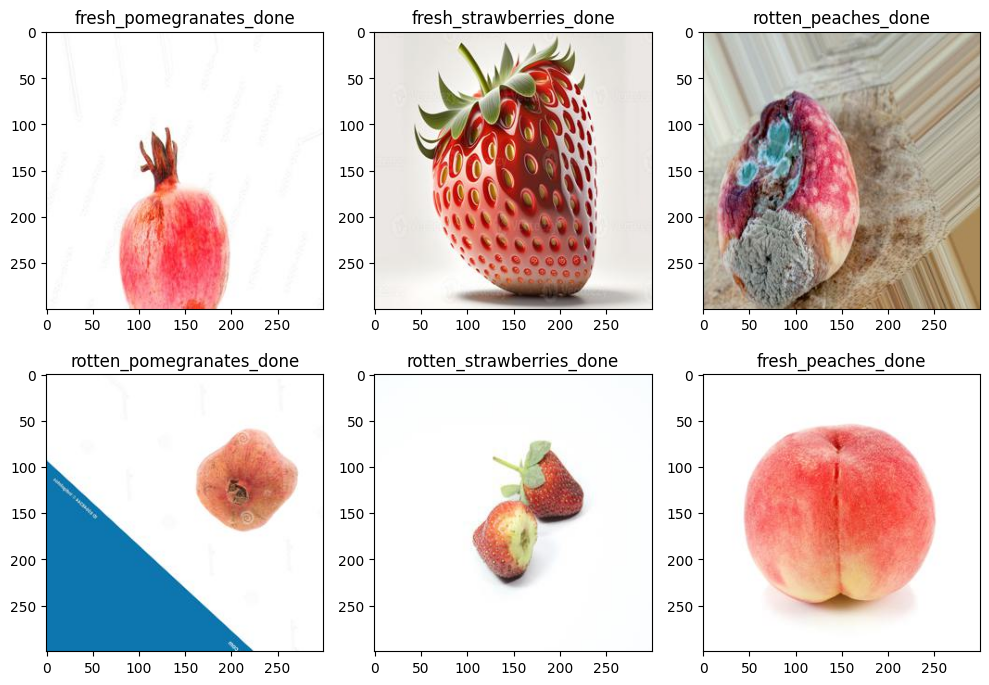

In [5]:
train_dir = '/content/Dataset/train/'

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs = axs.ravel()

for i, class_dir in enumerate(os.listdir(train_dir)):
    class_dir_path = os.path.join(train_dir, class_dir)

    if os.path.isdir(class_dir_path):
        files = os.listdir(class_dir_path)

        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        first_image_path = os.path.join(class_dir_path, images[0])

        img = load_img(first_image_path)
        axs[i].imshow(img)
        axs[i].set_title(class_dir)
        if i == 5:
          break

plt.tight_layout()
plt.show()


In [6]:
def generators(train_dir,val_dir,test_dir):
      train_datagen = ImageDataGenerator(rescale=1./255,
                                         rotation_range=30,
                                         brightness_range=[0.8,1.2],
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         fill_mode='nearest',
                                         horizontal_flip=True,
                                         vertical_flip=True)

      train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                          target_size=(300, 300),
                                                          color_mode='rgb',
                                                          class_mode='sparse',
                                                          batch_size=32,
                                                          shuffle=True,
                                                          seed=127,
                                                          subset='training',
                                                          interpolation='nearest',
                                                          keep_aspect_ratio=False)

      validation_datagen = ImageDataGenerator(rescale=1./255)
      validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                                                batch_size=32,
                                                                class_mode = 'sparse',
                                                                target_size=(300, 300),
                                                                shuffle=False)
      test_datagen = ImageDataGenerator(rescale=1./255)
      test_generator = validation_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=32,
                                                                class_mode = 'sparse',
                                                                target_size=(300, 300),
                                                                shuffle=False)
      return train_generator, validation_generator,test_generator
train_generator, validation_generator,test_generator=generators(train_dir,val_dir,test_dir)

Found 1071 images belonging to 6 classes.
Found 333 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


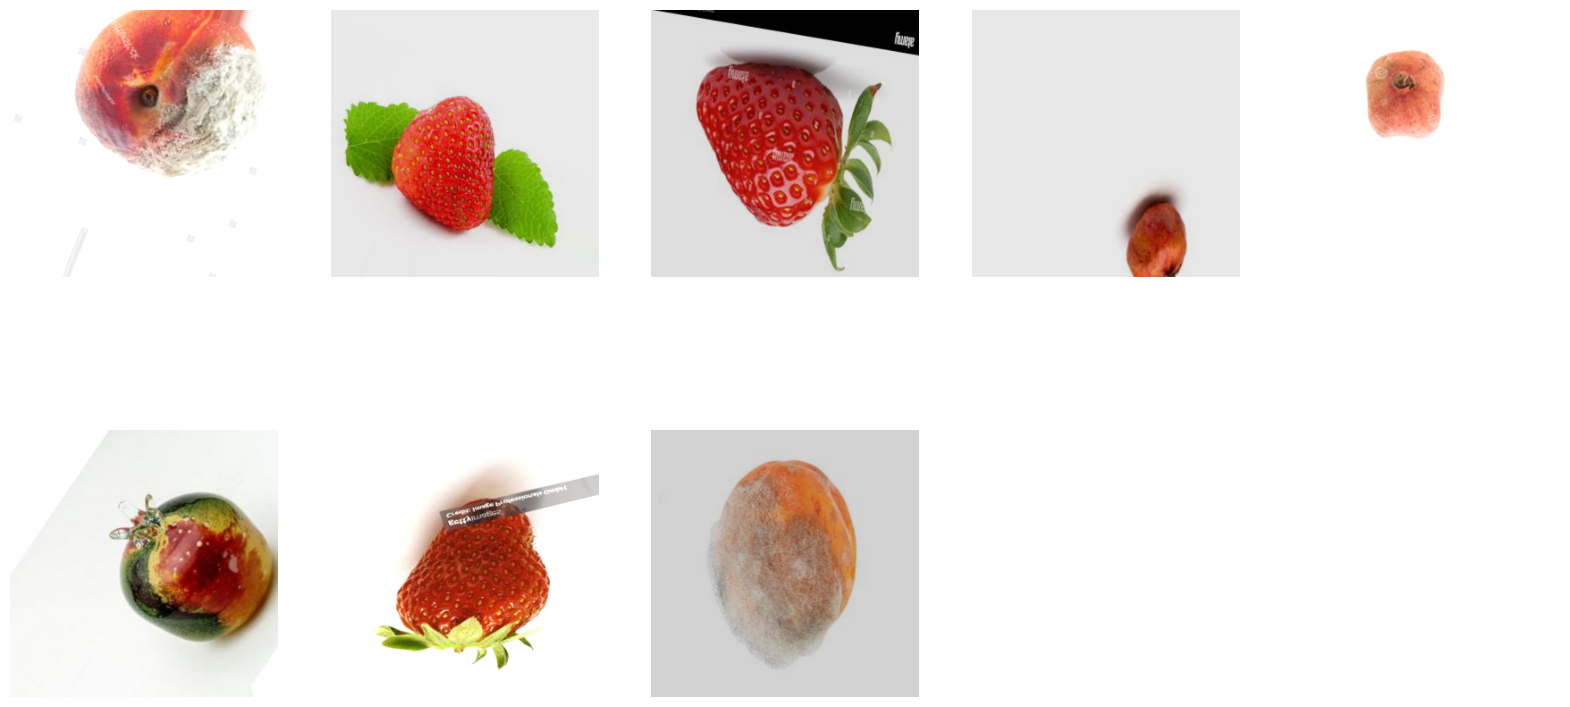

In [7]:
# Get a batch of images
x_batch, y_batch = next(train_generator)

# Plot the images
plt.figure(figsize=(20, 10))
for i in range(8):  # Display the first 10 images from the batch
    plt.subplot(2, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')  # Optional: Remove axis
plt.show()

In [8]:
#CNN MODEL
model=Sequential()

# model.add(Rescaling(1./255, ))

img_height=300
img_width=300
batch_size=8
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='valid',input_shape=(img_height, img_width, 3)))

model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(BatchNormalization())


model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)))

model.add(Dense(6,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)))

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - 57s 1s/step - loss: 4.2716 - accuracy: 0.2689 - val_loss: 4.1364 - val_accuracy: 0.2072
Epoch 2/15
34/34 [==============================] - 30s 904ms/step - loss: 3.6368 - accuracy: 0.4491 - val_loss: 3.9103 - val_accuracy: 0.1502
Epoch 3/15
34/34 [==============================] - 28s 830ms/step - loss: 3.1567 - accuracy: 0.5229 - val_loss: 3.8009 - val_accuracy: 0.2553
Epoch 4/15
34/34 [==============================] - 28s 830ms/step - loss: 2.8479 - accuracy: 0.5518 - val_loss: 3.7636 - val_accuracy: 0.2553
Epoch 5/15
34/34 [==============================] - 29s 850ms/step - loss: 2.6386 - accuracy: 0.5761 - val_loss: 4.5970 - val_accuracy: 0.2913
Epoch 6/15
34/34 [==============================] - 29s 868ms/step - loss: 2.4376 - accuracy: 0.6134 - val_loss: 5.5119 - val_accuracy: 0.1502
Epoch 7/15
34/34 [==============================] - 31s 891ms/step - loss: 2.2823 - accuracy: 0.6340 - val_loss: 5.1942 - val_accuracy: 0.1832
Epoch 8/15
34

In [10]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Epoch 1/10
34/34 [==============================] - 34s 839ms/step - loss: 0.6803 - accuracy: 0.7367 - val_loss: 0.3288 - val_accuracy: 0.8679
Epoch 2/10
34/34 [==============================] - 29s 845ms/step - loss: 0.2709 - accuracy: 0.9029 - val_loss: 0.2642 - val_accuracy: 0.8979
Epoch 3/10
34/34 [==============================] - 28s 812ms/step - loss: 0.1891 - accuracy: 0.9356 - val_loss: 0.2634 - val_accuracy: 0.9009
Epoch 4/10
34/34 [==============================] - 28s 812ms/step - loss: 0.1845 - accuracy: 0.9328 - val_loss: 0.2469 - val_accuracy: 0.9039
Epoch 5/10
34/34 [==============================] - 28s 819ms/step - loss: 0.1465 - accuracy: 0.9486 - val_loss: 0.2105 - val_accuracy: 0.9219
Epoch 6/10
34/34 [==============================] - 27s 798ms/step - loss: 0.1261 - accuracy: 0.9542 - val_loss: 0.2439 - val_accuracy: 0.9159
Epoch 7/10
34/34 [==============================] - 29s 848ms/step - loss: 0.1220 - accuracy: 0.9505 - val_loss: 0.1779 - val_accuracy: 0.9309